In [ ]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [19]:
# check for GPU for faster computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
batch_size = 64         # number of samples to process in parallel
block_size = 256        # context window size
max_iters = 5000        # number of training iterations
eval_interval = 500     # number of iterations between evaluations
learning_rate = 3e-4    # learning rate for the optimizer
eval_iters = 200        # number of iterations to evaluate the model
n_embd = 128            # number of embeddings
n_head = 6              # number of attention heads
n_layer = 3             # number of transformer layers
dropout = 0.2           # dropout rate

In [21]:
dataset = load_dataset('wikipedia', '20220301.en', split='train', trust_remote_code=True)
subset = dataset.shuffle().select(range(100))

text = ' '.join(subset['text'])
chars = ''.join(sorted(set(text)))
print(chars[:100])

vocab_size = len(chars)
print(vocab_size)

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]


 !"#$%&'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{|}~ £µ·½ÉÖáâã
165


In [54]:
dataset.shape

(6458670, 4)

In [22]:
stoi = { ch:i for i, ch in enumerate(chars) }     # mapping: string -> int
itos = { i:ch for i, ch in enumerate(chars) }     # mapping: int -> string
encode = lambda s: [stoi[c] for c in s]           # convert string to list of integers
decode = lambda l: ''.join([itos[i] for i in l])  # convert list of integers to string

data = torch.tensor(encode(text), dtype=torch.long)
print(data)

tensor([49, 60, 77,  ..., 73, 79, 78])


In [23]:
# split the data into training (80%) and validation (20%)
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

In [24]:
def get_batch(split='train'):
    """
    Get a random batch of data from the training or validation set.
    """
    data = train_data if split == 'train' else val_data
    starting_indices = torch.randint(len(data) - block_size, (batch_size, 1)) # (batch_size, 1)
    x = torch.stack([data[i:i+block_size] for i in starting_indices]) # (batch_size, block_size)
    y = torch.stack([data[i+1:i+block_size+1] for i in starting_indices]) # (batch_size, block_size)
    x, y = x.to(device), y.to(device)
    return x, y

In [25]:
@torch.no_grad() # disable gradient computation because we are only evaluating
def estimate_loss(model):
    """
    Estimate the loss of the model on the training and validation sets.
    """
    out = {}
    model.eval() # set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters) # store the loss for each iteration
        for k in range(eval_iters):
            X, Y = get_batch(split) # get random batch
            logits, loss = model.forward(X, Y) # pass through the neural network and return loss
            losses[k] = loss.item() # store the loss
        out[split] = losses.mean()
    model.train() # set the model back to training mode
    return out # {'train': train_loss, 'val': val_loss}

In [26]:
class Head(nn.Module):
    """
    A single attention head.
    """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # key projection
        self.query = nn.Linear(n_embd, head_size, bias=False) # query projection
        self.value = nn.Linear(n_embd, head_size, bias=False) # value projection
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        B: batch size, T: block size, C: channels, H: head size
        x: (B, T, C)
        Scaled dot-product attention.
        """

        B, T, C = x.shape
        k = self.key(x) # (B, T, H)
        q = self.query(x) # (B, T, H)

        wei = q @ k.transpose(-2,-1) * k.shape[-1]**(-0.5) # (B, T, H) @ (B, H, T) = (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        v = self.value(x) # (B, T, H)
        out = wei @ v # (B, T, T) @ (B, T, H) = (B, T, H)
        return out

In [27]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention layer.
    """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [28]:
class FeedFoward(nn.Module):
    """
    Feed-forward neural network with a single hidden layer.
    """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [29]:
class Block(nn.Module):
    """
    A transformer block consists of a multi-head self-attention layer followed by a feed-forward layer
    """

    def __init__(self, n_embd, n_head):
        """
        n_embd: embedding dimension
        n_head: number of attention heads
        """

        super().__init__()
        head_size = n_embd // n_head # determine the size of each head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) # layer normalization
        self.ln2 = nn.LayerNorm(n_embd) # layer normalization

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [50]:
class LLM(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.normalization = nn.LayerNorm(n_embd) # normalization layer
        self.output = nn.Linear(n_embd, vocab_size) # output layer

        self.apply(self._init_weights) # initialize the weights on each layer

    def _init_weights(self, module):
        if isinstance(module, nn.Linear): # if linear layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02) # set the weights to have a normal distribution
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # set the bias to zero
        elif isinstance(module, nn.Embedding): # if embedding layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02) # set the weights to have a normal distribution

    def forward(self, indices, targets=None):
        """
        B: batch_size, T: block_size, C: n_embd
        indices: (B, T) tensor of integers
        targets: (B, T) tensor of integers
        """
        
        B, T = indices.shape
        token_embedding = self.token_embedding_table(indices) # (B, T, C)
        position_embedding = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
        x = token_embedding + position_embedding # (B, T, C)
        x = self.blocks(x) # (B, T, C)
        x = self.normalization(x) # (B, T, C)
        logits = self.output(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, indices, tokens=100):
        """
        B: batch_size, T: block_size, C: n_embd
        indices: (B, T) tensor of integers to start the generation from
        tokens: number of tokens to generate
        """

        for _ in range(tokens):
            context_indices = indices[:, -block_size:] # (B, T) get the last block_size tokens
            logits, loss = self.forward(context_indices) # get the logits and loss
            logits = logits[:, -1, :] # (B, C) get the logits for the last token
            probs = F.softmax(logits, dim=-1) # (B, C) convert logits to probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) sample from the distribution
            indices = torch.cat((indices, idx_next), dim=1) # (B, T+1) append the new token
        return indices

model = LLM()
m = model.to(device)

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

val_loss = []

for iter in range(max_iters+1):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        val_loss.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train') # get a random batch of data

    logits, loss = model(xb, yb) # forward pass through the neural network, compute logits and loss
    optimizer.zero_grad(set_to_none=True) # clear previous gradients
    loss.backward() # backpropagate to compute gradients
    optimizer.step() # update the model weights

step 0: train loss 5.1026, val loss 5.1041
step 500: train loss 2.5227, val loss 2.6283
step 1000: train loss 1.9286, val loss 2.1898
step 1500: train loss 1.6673, val loss 2.0358
step 2000: train loss 1.5227, val loss 1.9905
step 2500: train loss 1.4403, val loss 1.9576
step 3000: train loss 1.3769, val loss 1.9762
step 3500: train loss 1.3225, val loss 1.9679
step 4000: train loss 1.2783, val loss 1.9731
step 4500: train loss 1.2352, val loss 1.9583
step 5000: train loss 1.2085, val loss 1.9625


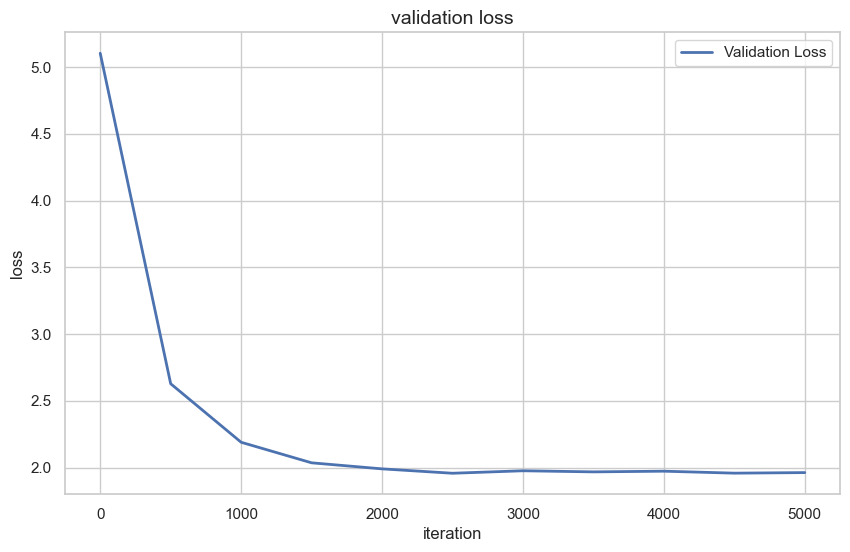

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(range(0, max_iters + 1, eval_interval), val_loss, label='Validation Loss', color='b', linewidth=2)

plt.xlabel('iteration', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('validation loss', fontsize=14)
plt.legend()
plt.show()


In [96]:
context = torch.zeros((1, 1), dtype=torch.long, device=device) # initialize context
print(decode(m.generate(context, tokens=200)[0].tolist())) # generate text


The conspition Jeb Volebourne either eventtumic for even asilents.

At urporsed slabeit wining, family the populater yime-of thir on-levolving arous commeratizal. It the first apported as the roadys (
